In [149]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request

%matplotlib inline

In [150]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

def ls_mutation(tsp_objective_function,p, k=1):
    if k == 0:
        return (tsp_objective_function(p), p)
    
    permutations = [p]
    for i in range(len(p)):
        for j in range(i+1,len(p)):
                q = p.copy()
                q[i], q[j] = q[j], q[i]
                permutations.append(q)
    
    p_s = [ls_mutation(tsp_objective_function,s,k-1) for s in permutations]
    return min(p_s, key = lambda t: t[0])[1]

In [151]:
def PMX(ind1, ind2):
    a = np.random.choice(len(ind1)-2, 2, False)
    i, j = a.min(), a.max()
    np.vstack((ind1[i:j],ind2[i:j])).T
    match = np.zeros(len(ind1)).astype(int)
    for p in np.vstack((ind1[i:j],ind2[i:j])).T:
        match[p[0]] = p[1]    
        match[p[1]] = p[0]
    
    child1 = np.concatenate((ind1[:i], ind2[i:j], ind1[j:]))
    child2 = np.concatenate((ind2[:i], ind1[i:j], ind2[j:]))

    for k in np.delete(np.arange(len(ind1)), np.arange(i,j)):
        while child1[k] in ind2[i:j]:
            index = np.where(ind2[i:j] == child1[k])[0][0]
            child1[k] = ind1[i:j][index]
        while child2[k] in ind1[i:j]:
            index = np.where(ind1[i:j] == child2[k])[0][0]
            child2[k] = ind2[i:j][index]
    return child1, child2

In [160]:
def sga(tsp_objective_function, n):
    population_size = 500
    chromosome_length = n
    number_of_offspring = population_size
    crossover_probability = 0.95
    mutation_probability = 0.25
    number_of_iterations = 250

    time0 = time.time()

    best_objective_value = np.Inf
    best_chromosome = np.zeros((1, chromosome_length))

    costs = np.zeros(number_of_iterations)
    
    # generating an initial population
    current_population = np.zeros((population_size, chromosome_length), dtype=np.int64)
    for i in range(population_size):
        current_population[i, :] = np.random.permutation(chromosome_length)

    # evaluating the objective function on the current population
    objective_values = np.zeros(population_size)
    for i in range(population_size):
        objective_values[i] = tsp_objective_function(current_population[i, :])

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)

        # creating the children population
        children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = PMX(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy())
            else:
                children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = current_population[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = reverse_sequence_mutation(children_population[i, :])

        # evaluating the objective function on the children population
        children_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_objective_values[i] = tsp_objective_function(children_population[i, :])

        # replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population = np.vstack([current_population, children_population])

        I = np.argsort(objective_values)
        current_population = current_population[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]

        # recording some statistics
        if best_objective_value < objective_values[0]:
            best_objective_value = objective_values[0]
        best_chromosome = current_population[0, :]
        costs[t] = objective_values[0]
        #print('%3d %14.8f %12.8f %12.8f %12.8f %12.8f' % (t, time.time() - time0, objective_values.min(), objective_values.mean(), objective_values.max(), objective_values.std()))
        
    return costs

### QAP

In [220]:
instances = [12,14,15,17,18,20,21,22,24,25,27,28,50,60,80]
urls = {n: 'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug{}.dat'.format(n) for n in instances}
urls[50] = 'http://anjos.mgi.polymtl.ca/qaplib/data.d/tai50a.dat'
urls[60] = 'http://anjos.mgi.polymtl.ca/qaplib/data.d/tai60a.dat'
urls[80] = 'http://anjos.mgi.polymtl.ca/qaplib/data.d/tai80a.dat'

opt = {12: 578, 14: 1014, 15: 1150, 17: 1732, 18:1930, 20:2570, 21:2438, 22:3596 ,24:3488 ,25:3744 ,27:5234 ,28:5166 , 50:4938796, 60:7205962 , 80:13499184}

In [221]:
def get_data(n):
    qap_instance_file = urllib.request.urlopen(urls[n])
    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])
    
    A = np.empty((n, n))
    if n != 50 and n!=60 and n!=80:
        qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    B = np.empty((n, n))
    if n != 50: #and n!=60:
        qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    return A, B

In [222]:
def qap_objective_function_AB(A,B,n):
    def f(p):
        s = 0.0
        for i in range(n):
            s += (A[i, :] * B[p[i], p]).sum()
        return s
    return f

In [223]:
d = {}

In [224]:
for n in instances:
    A, B = get_data(n)

    t0 = time.time()

    d[n] = sga(qap_objective_function_AB(A,B,n), n)
    print('opt solution: ',opt[n],' sga solution: ',d[n].min(), "with time: ", time.time() - t0)
    

opt solution:  578  sga solution:  578.0 with time:  15.574023246765137
opt solution:  1014  sga solution:  1030.0 with time:  16.97442102432251
opt solution:  1150  sga solution:  1170.0 with time:  17.64456009864807
opt solution:  1732  sga solution:  1764.0 with time:  19.111804723739624
opt solution:  1930  sga solution:  1966.0 with time:  19.8576717376709
opt solution:  2570  sga solution:  2658.0 with time:  21.58815598487854
opt solution:  2438  sga solution:  2624.0 with time:  22.006715536117554
opt solution:  3596  sga solution:  3668.0 with time:  22.857485055923462
opt solution:  3488  sga solution:  3644.0 with time:  24.479217290878296
opt solution:  3744  sga solution:  3916.0 with time:  25.148694038391113
opt solution:  5234  sga solution:  5564.0 with time:  26.52067542076111
opt solution:  5166  sga solution:  5354.0 with time:  27.61535954475403
opt solution:  4938796  sga solution:  5357078.0 with time:  44.36911654472351
opt solution:  7205962  sga solution:  790

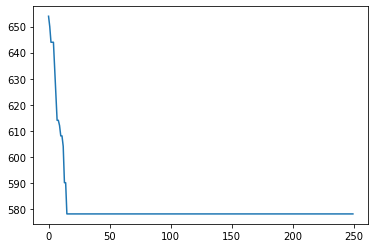

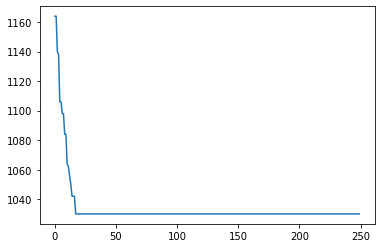

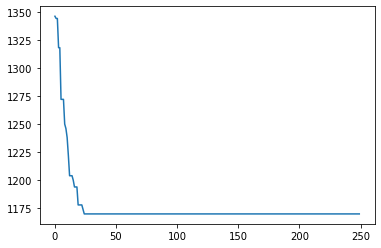

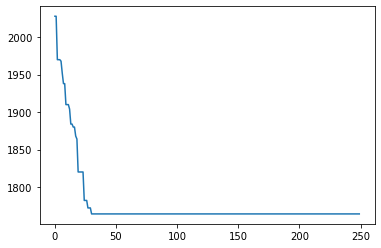

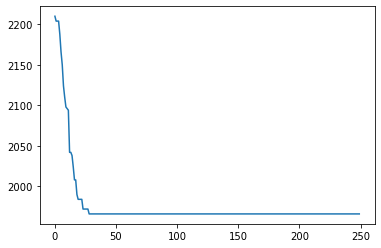

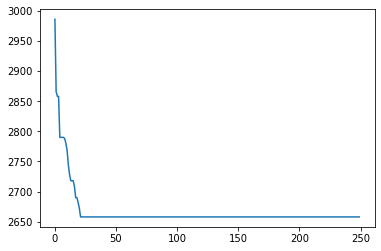

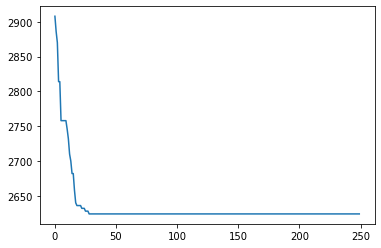

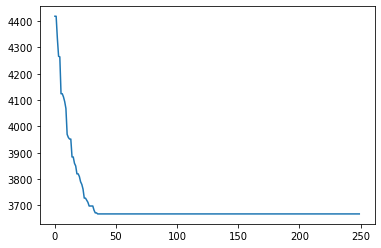

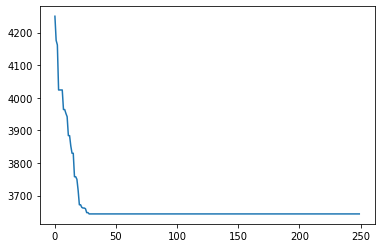

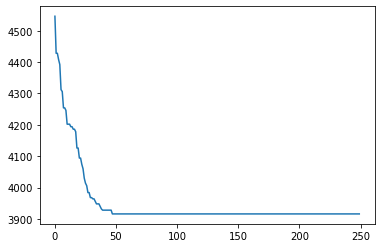

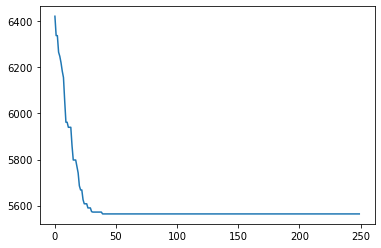

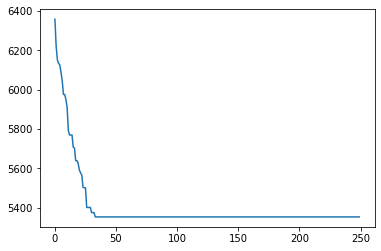

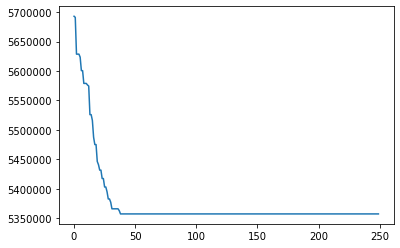

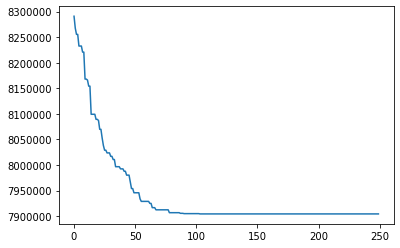

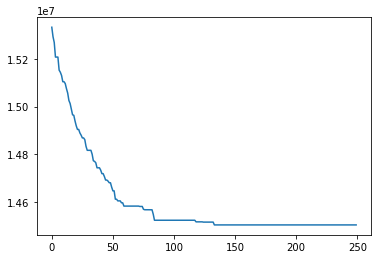

In [225]:
for n in instances:
    plt.figure()
    plt.title = str(n)
    plt.plot(d[n])
    plt.show()

In [159]:
for i in range(10):
    A, B = get_data(12)
    t0 = time.time()
    c = sga(qap_objective_function_AB(A,B,12), 12)
    print('opt solution: ',opt[12],' sga solution: ',c.min(), "with time: ", time.time() - t0)

opt solution:  578  sga solution:  578.0 with time:  120.09869432449341
opt solution:  578  sga solution:  586.0 with time:  113.29382586479187
opt solution:  578  sga solution:  582.0 with time:  123.17524433135986
opt solution:  578  sga solution:  578.0 with time:  116.59573006629944
opt solution:  578  sga solution:  578.0 with time:  113.69608759880066
opt solution:  578  sga solution:  586.0 with time:  124.80715990066528
opt solution:  578  sga solution:  578.0 with time:  114.28872442245483
opt solution:  578  sga solution:  578.0 with time:  113.83638834953308
opt solution:  578  sga solution:  586.0 with time:  118.15496921539307
opt solution:  578  sga solution:  578.0 with time:  116.05986261367798
